<a href="https://colab.research.google.com/github/kotatakehara/Self-efficacy/blob/devel/Kendama_change_Class_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### すること
変化率rtの値をもう少し細かくしてみる（rtの値を4つくらい使ってみる） \\
分散の変化量であるαとβの値を変えてみる \\
想像よりもVRは難しいから成功率をもう少し低下させる

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [80]:
class Kendama():    #学習率、皿の移動割合、難易度調整の割合、難易度の初期値を格納
  def __init__(self, get_times): #get_timesはけん玉の総試行回数
    # self.alpha = alpha    #学習率
    # self.beta = beta    #学習率
    # self.a = a    #皿の移動割合
    # self.rt = rt    #難易度調整の割合
    # self.success_rate = success_rate #難易度調整を行う際の成功率の指標
    # self.fail_rate = fail_rate #難易度調整を行う際の失敗率の指標
    self.B = np.random.normal(loc=0, scale=1, size=get_times)  # けん玉の落下データを格納する配列（locは平均、scaleは標準偏差、sizeは導かれる値の数）つまり各試行時のけん玉の落下位置

  def Nonajustment(self, r): #難易度を調整しない場合の結果を表す関数
    dispersion = [1**2]     #被験者のやる気を表す分散を格納する配列
    p = [0]       #皿のガウス分布の平均値を格納する配列
    x = []        #皿の位置変化を格納する配列
    for i in range(len(self.B)):
      x.append(i)
      D = np.random.normal(loc=p[i], scale=np.sqrt(dispersion[i]), size=1)      #皿の位置を表す変数
      if self.B[i] >= D-r and self.B[i] <= D+r:     #成功した時の分散の変化
        p.append(p[i])
        dispersion.append(dispersion[i]-self.alpha)
        if dispersion[i+1] < 0:     #分散が０未満になることを防ぐ
          dispersion[i+1] = 0
      else:       #失敗した時の分散の変化
        p.append(self.a*self.B[i]+(1-self.a)*p[i])
        dispersion.append(dispersion[i]+self.beta)
    x.append(len(self.B))
    return x,p,dispersion

  def Ajustment(self, r, trial_times, rt, alpha, beta, a, success_rate, fail_rate): #難易度を調整した場合（半径を小さくしたり大きくしたり）の結果を表す関数
    dispersion = [1**2]     #被験者のやる気を表す分散を格納する配列
    p = [0]       #皿のガウス分布の平均値を格納する配列
    # success_rate = 0.66 #難易度調整を行う際の成功率の指標
    # fail_rate = 0.66 #難易度調整を行う際の失敗率の指標
    success = 0    #成功回数を表す変数
    trial = 0       #試行回数を表す変数
    x = []
    R = []
    R.append(r)
    for i in range(len(self.B)):
      trial += 1
      x.append(i)
      R.append(r)
      D = np.random.normal(loc=p[i], scale=np.sqrt(dispersion[i]), size=1)      #皿の位置を表す変数
      if self.B[i] >= D-r and self.B[i] <= D+r:     #成功した時の分散の変化
        p.append(p[i])
        dispersion.append(dispersion[i]-alpha)
        success += 1
        if dispersion[i+1] < 0:     #分散が０未満になることを防ぐ
          dispersion[i+1] = 0
      else:       #失敗した時の分散の変化
        p.append(a*self.B[i]+(1-a)*p[i])
        dispersion.append(dispersion[i]+beta)
      if trial >= trial_times and success/trial >= success_rate:    #trial_timesが１の時、失敗や成功するたびに変更するようになっている
        trial = 0
        success = 0
        r -= rt
        if r <= 0:    #半径が０以下にならないようにするための処置
          r = 0.5
      elif trial >= trial_times and (trial-success)/trial >= fail_rate:
        trial = 0
        success = 0
        r += rt
    x.append(len(self.B))
    return x,p,dispersion,R

In [81]:
class kendama(Kendama):
  def __init__(self, get_times):
    super().__init__(get_times)

  def show_Non(self, r): #rはけん玉の半径を示す
    self.Non_r = []  # 各半径での変化を格納すための配列

    # 各半径の変化を計算
    for i in range(5, 35, 5):
        r = i / 10
        Non_x, Non_p, Non_dispersion = self.Nonajustment(r)
        Non = [Non_x, Non_p, Non_dispersion]
        self.Non_r.insert(len(self.Non_r), Non)

    # 各半径の変化を描画
    fig, axs = plt.subplots( 2, len(self.Non_r), figsize=(16, 2 * 3), dpi=100, sharey="row")
    fig.subplots_adjust(hspace=0.5)
    for i, (Non_x, Non_p, Non_dispersion) in enumerate(self.Non_r):
        axs[0, i].plot(Non_x, Non_p, color='r')
        axs[1, i].plot(Non_x, Non_dispersion, color='b')

        axs[0, i].set_title(f"r={0.5*(i+1)}, D")
        axs[1, i].set_title(f"r={0.5*(i+1)}, σ")

    for ax in axs.flat:
        ax.set_xlabel("t (times)")

    axs[0, 0].set_ylabel("D")

    axs[1, 0].set_ylabel('σ')

    plt.tight_layout()
    plt.savefig(f"Non_Ajustment.png")
    files.download(f'Non_Ajustment.png')
    plt.show()

  def show_ajustment_from_min(self, r, trial_times, rt, alpha, beta, a, success_rate, fail_rate):

    # 難しい方から調整した場合の分散のデータを格納
    self.A_min_list = []

    for i in range(5):
        A_x, A_p, A_dispersion, R = self.Ajustment(r, trial_times, rt, alpha, beta, a, success_rate, fail_rate)
        self.A_min_list.append((A_x, A_p, A_dispersion, R))

    # サブプロットの設定
    fig, axs = plt.subplots(3, len(self.A_min_list), figsize=(16, 2 * 3), sharey="row")

    # グラフのプロット
    for i, (A_x, A_p, A_dispersion, R) in enumerate(self.A_min_list):
        axs[0, i].plot(A_x, A_p, color='r')
        axs[1, i].plot(A_x, A_dispersion, color='b')
        axs[2, i].plot(A_x, R, color='g')

        axs[0, i].set_title(f"mean (Trial {i+1})")
        axs[1, i].set_title(f"dispersion (Trial {i+1})")
        axs[2, i].set_title(f"r (Trial {i+1})")

    plt.tight_layout()
    plt.show()

  def show_all(self, title):
    # サブプロットの設定
    fig, axs = plt.subplots(3, 2, figsize=(16, 2* 3),sharey="row")

    for ax in axs.flat:
        ax.set_xlabel("t (times)")
    axs[0, 0].set_ylabel('D')
    axs[1, 0].set_ylabel('σ')
    axs[2, 0].set_ylabel('r')

    # グラフのプロット
    axs[0, 0].plot(self.A_min_list[0][0], self.A_min_list[0][1],color='r')
    axs[1, 0].plot(self.A_min_list[0][0], self.A_min_list[0][2],color='b')
    axs[1, 0].set_ylim(0,2)
    axs[2, 0].plot(self.A_min_list[0][0], self.A_min_list[0][3],color='g')
    axs[0, 0].set_title(f"D (Ajustment_from_min)")
    axs[1, 0].set_title(f"σ (Ajustment_from_min)")
    axs[2, 0].set_title(f"r (Ajustment_from_min)")

    axs[0, 1].plot(self.A_min_list[1][0], self.A_min_list[1][1],color='r')
    axs[1, 1].plot(self.A_min_list[1][0], self.A_min_list[1][2],color='b')
    axs[1, 1].set_ylim(0,2)
    axs[2, 1].plot(self.A_min_list[1][0], self.A_min_list[1][3],color='g')
    axs[0, 1].set_title(f"D (Ajustment_from_min)")
    axs[1, 1].set_title(f"σ (Ajustment_from_min)")
    axs[2, 1].set_title(f"r (Ajustment_from_min)")

    # レイアウトの調整
    plt.tight_layout()
    plt.savefig(f"Ajustment({title}).png")
    files.download(f'Ajustment({title}).png')
    # グラフの表示
    plt.show()





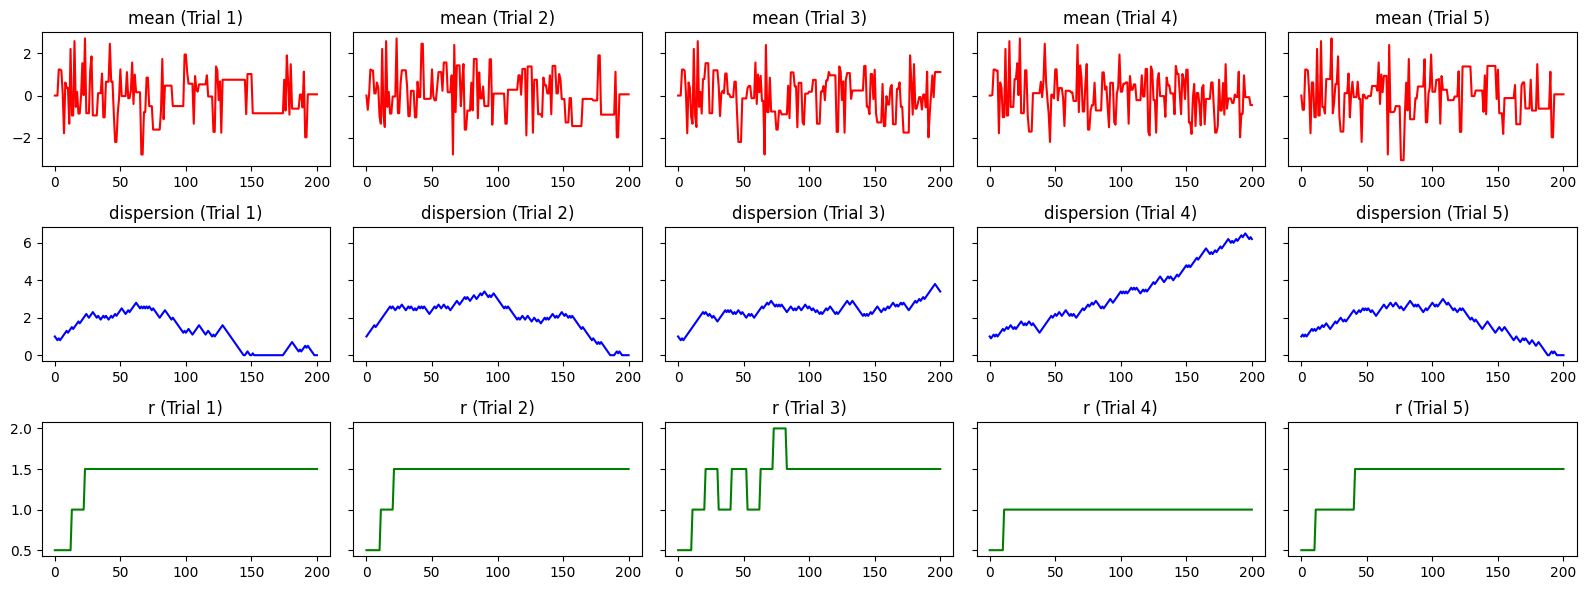

In [82]:
alpha = 0.1       #成功した場合のやる気の変化量を表す変数
beta = 0.1    #失敗した場合のやる気の変化量を表す変数
a = 1  # どれだけの割合皿の中心を落下地点に移動させるかを表す変数（a=1なら落下地点に移動）
rt = 0.5
trial_times = 10
get_times = 200
success_rate = 0.66 #難易度調整を行う際の成功率の指標
fail_rate = 0.66 #難易度調整を行う際の失敗率の指標
kendama_change = kendama(get_times)
# kendama_change.show_Non(1)
kendama_change.show_ajustment_from_min(0.5, trial_times, rt, alpha, beta, a, success_rate, fail_rate)

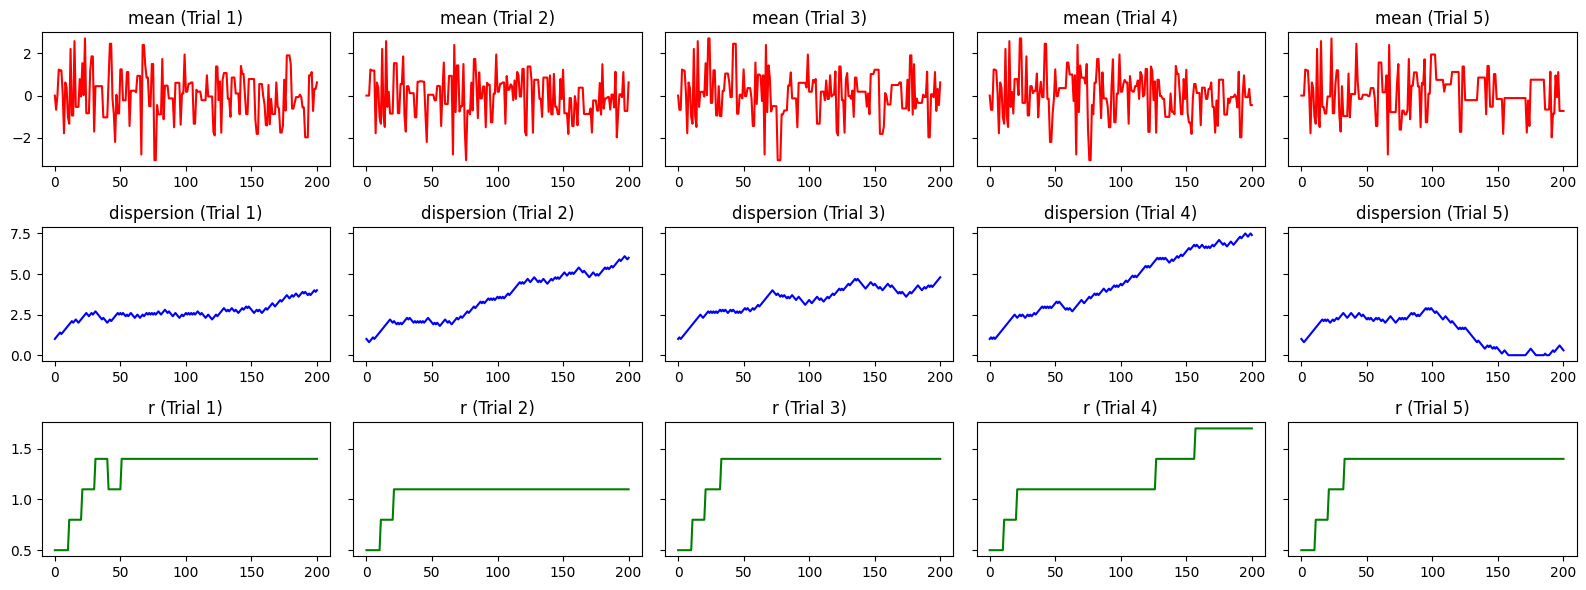

In [84]:
rt = 0.3
kendama_change.show_ajustment_from_min(0.5, trial_times, rt, alpha, beta, a, success_rate, fail_rate)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

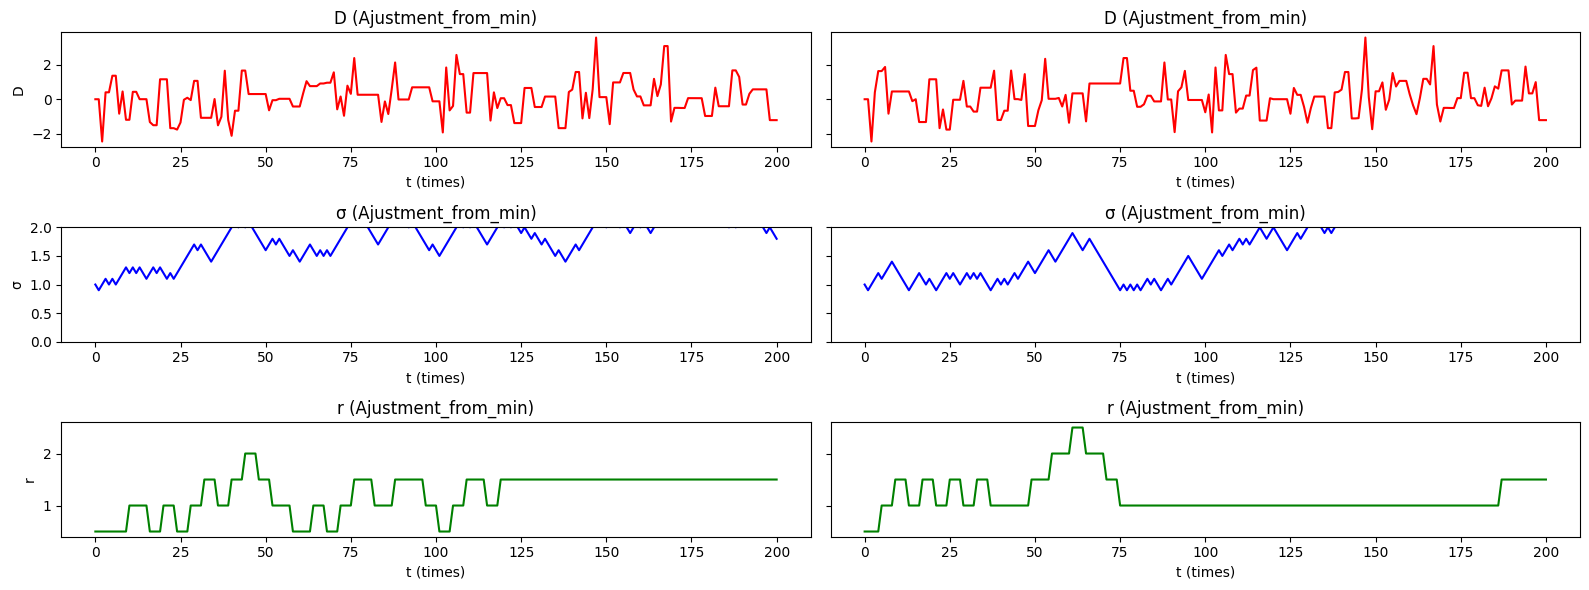

In [58]:
kendama_change.show_all("trial_times = 10")

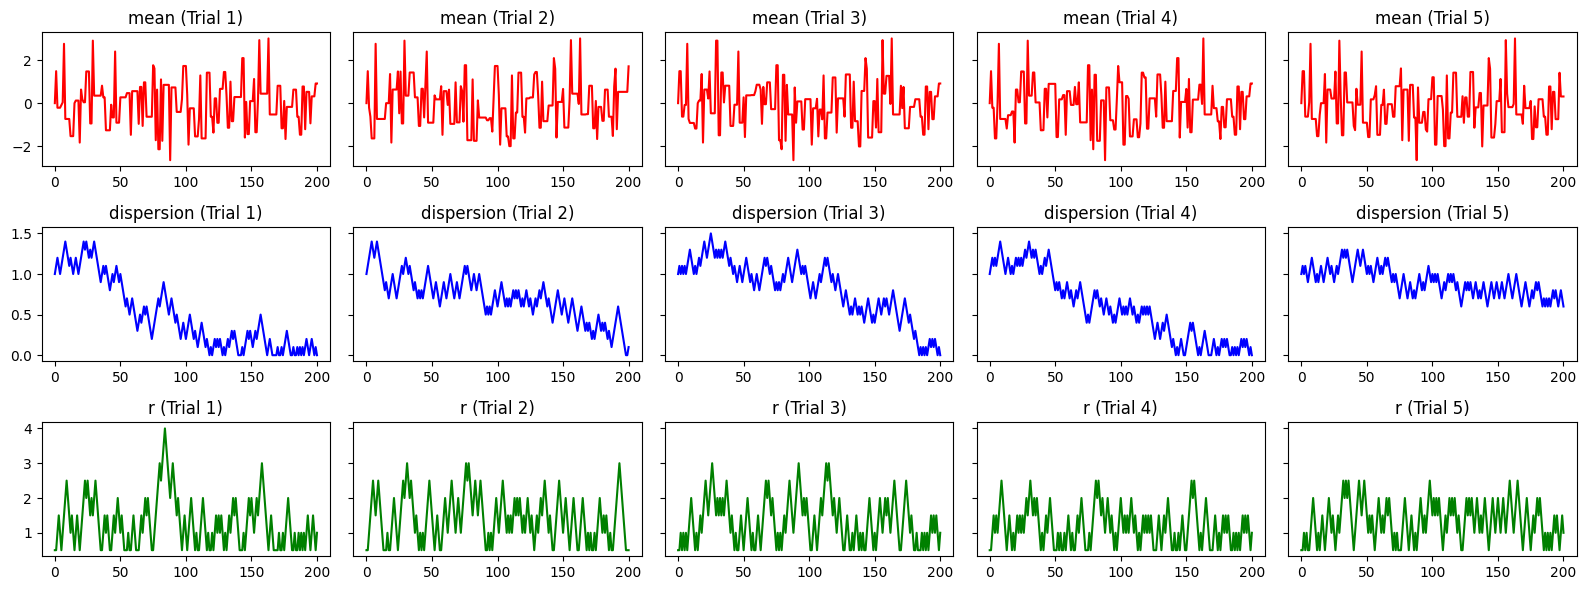

In [85]:
alpha = 0.1       #成功した場合のやる気の変化量を表す変数
beta = 0.1    #失敗した場合のやる気の変化量を表す変数
a = 1  # どれだけの割合皿の中心を落下地点に移動させるかを表す変数（a=1なら落下地点に移動）
rt = 0.5
trial_times = 1
get_times = 200
success_rate = 0.66 #難易度調整を行う際の成功率の指標
fail_rate = 0.66 #難易度調整を行う際の失敗率の指標
kendama_change = kendama(get_times)
# kendama_change.show_Non(1)

kendama_change.show_ajustment_from_min(0.5, trial_times, rt, alpha, beta, a, success_rate, fail_rate)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

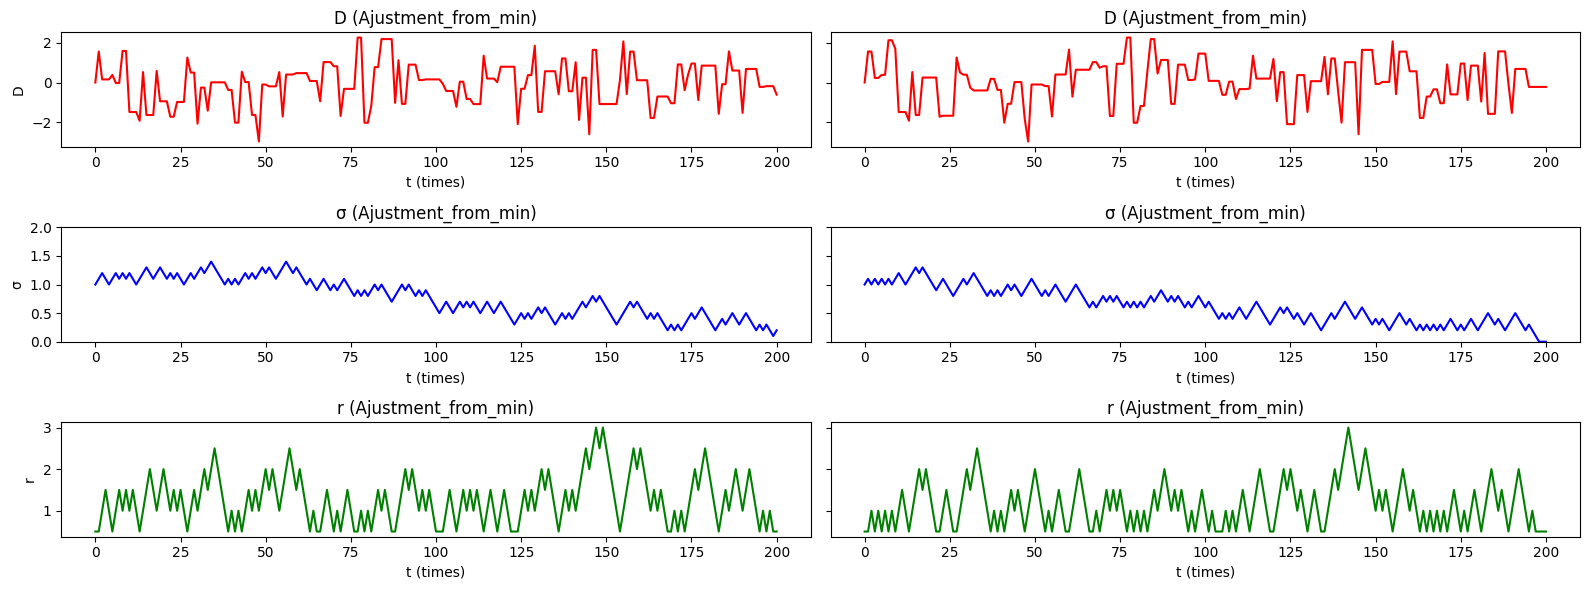

In [60]:
kendama_change.show_all("trial_times = 1")